In [1]:
import os
from typing import Dict, List, Any, TypedDict, Annotated
from dataclasses import dataclass
from datetime import datetime
import json

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image,display
from langgraph.checkpoint.memory import MemorySaver

In [2]:
# tool for doing Web Searcg
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")
os.environ["GOOGLE_API_KEY"]= os.getenv("GOOGLE_API_KEY")

os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]= os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]= os.getenv("LANGCHAIN_TRACING_V2")
os.environ["TAVILY_API_KEY"]= os.getenv("TAVILY_API_KEY")

# Define our LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-4o-mini")

In [3]:
@dataclass
class SupportTicket:
    """Represents a customer support ticket"""
    id: str
    customer_name: str
    email: str
    subject: str
    description: str
    category: str = ""
    priority: str = ""
    status: str = "open"
    assigned_agent: str = ""
    resolution: str = ""
    created_at: str = ""

class AgentState(TypedDict):
    """State shared between all agents"""
    ticket: SupportTicket
    messages: List[str]
    next_agent: str
    resolution_complete: bool
    escalation_needed: bool


class TicketManagerAgent:
    """Agent responsible for categorizing and prioritizing tickets"""
    
    def __init__(self, llm):
        self.llm = llm
        self.name = "TicketManager Agent"
    
    def process(self, state: AgentState) -> AgentState:
        ticket = state["ticket"]
        
        TicketManager_prompt = f"""
        You are a customer support TicketManager agent. Analyze this support ticket and:
        1. Categorize it (Technical, Billing, Account, Product, Other)
        2. Set priority (Low, Medium, High, Critical)
        3. Determine the best agent to handle it
        
        Ticket Details:
        Subject: {ticket.subject}
        Description: {ticket.description}
        Customer: {ticket.customer_name}
        
        Respond in JSON format:
        {{
            "category": "category_name",
            "priority": "priority_level",
            "reasoning": "brief explanation",
            "recommended_agent": "Technical Agent or Escalation Agent"
        }}
        """
        
        response = self.llm.invoke([SystemMessage(content=TicketManager_prompt)])
        
        try:
            result = json.loads(response.content)
            ticket.category = result["category"]
            ticket.priority = result["priority"]
            
            message = f"[{self.name}] Ticket TicketManaged - Category: {ticket.category}, Priority: {ticket.priority}"
            state["messages"].append(message)
            
            # Route to appropriate agent
            if result["recommended_agent"] == "Technical Agent" and ticket.category == "Technical":
                state["next_agent"] = "technical"
            else:
                state["next_agent"] = "escalation"
                
        except json.JSONDecodeError:
            # Fallback if JSON parsing fails
            ticket.category = "Other"
            ticket.priority = "Medium"
            state["messages"].append(f"[{self.name}] TicketManager completed with default values")
            state["next_agent"] = "technical"
        
        return state

class TechnicalAgent:
    """Agent specialized in handling technical support issues"""
    
    def __init__(self, llm):
        self.llm = llm
        self.name = "Technical Agent"
    
    def process(self, state: AgentState) -> AgentState:
        ticket = state["ticket"]
        
        technical_prompt = f"""
        You are a technical support specialist. A customer has reported the following issue:
        
        Category: {ticket.category}
        Priority: {ticket.priority}
        Subject: {ticket.subject}
        Description: {ticket.description}
        
        Provide a helpful technical solution. If the issue is too complex or requires account access,
        recommend escalation. Otherwise, provide step-by-step troubleshooting.
        
        Respond in JSON format:
        {{
            "can_resolve": true/false,
            "solution": "detailed solution or troubleshooting steps",
            "escalate": true/false,
            "escalation_reason": "reason if escalation needed"
        }}
        """
        
        response = self.llm.invoke([SystemMessage(content=technical_prompt)])
        
        try:
            result = json.loads(response.content)
            
            if result["can_resolve"] and not result["escalate"]:
                ticket.resolution = result["solution"]
                ticket.status = "resolved"
                ticket.assigned_agent = self.name
                state["resolution_complete"] = True
                state["messages"].append(f"[{self.name}] Issue resolved successfully")
            else:
                state["escalation_needed"] = True
                state["next_agent"] = "escalation"
                state["messages"].append(f"[{self.name}] Escalating to human agent: {result.get('escalation_reason', 'Complex issue')}")
                
        except json.JSONDecodeError:
            state["escalation_needed"] = True
            state["next_agent"] = "escalation"
            state["messages"].append(f"[{self.name}] Error processing - escalating to human agent")
        
        return state

class EscalationAgent:
    """Agent that handles complex cases requiring human intervention"""
    
    def __init__(self, llm):
        self.llm = llm
        self.name = "Escalation Agent"
    
    def process(self, state: AgentState) -> AgentState:
        ticket = state["ticket"]
        
        escalation_prompt = f"""
        You are an escalation specialist handling a complex support case that requires human intervention.
        
        Ticket Details:
        Category: {ticket.category}
        Priority: {ticket.priority}
        Subject: {ticket.subject}
        Description: {ticket.description}
        
        Create a comprehensive handoff summary for the human agent including:
        1. Situation summary
        2. Recommended actions
        3. Customer communication template
        
        Respond in JSON format:
        {{
            "handoff_summary": "detailed summary for human agent",
            "recommended_actions": ["action1", "action2", "action3"],
            "customer_message": "professional message to send to customer"
        }}
        """
        
        response = self.llm.invoke([SystemMessage(content=escalation_prompt)])
        
        try:
            result = json.loads(response.content)
            
            ticket.resolution = f"Escalated to human agent. Summary: {result['handoff_summary']}"
            ticket.status = "escalated"
            ticket.assigned_agent = "Human Agent (Pending)"
            
            state["resolution_complete"] = True
            state["messages"].append(f"[{self.name}] Case escalated to human agent with comprehensive handoff")
            
        except json.JSONDecodeError:
            ticket.resolution = "Escalated to human agent for manual review"
            ticket.status = "escalated"
            ticket.assigned_agent = "Human Agent (Pending)"
            state["resolution_complete"] = True
            state["messages"].append(f"[{self.name}] Case escalated to human agent")
        
        return state


In [4]:
def create_support_workflow():
    """Create the LangGraph workflow for the support system"""
    
    # Initialize agents
    TicketManager_agent = TicketManagerAgent(llm)
    technical_agent = TechnicalAgent(llm)
    escalation_agent = EscalationAgent(llm)
    
    # Define the workflow graph
    workflow = StateGraph(AgentState)
    
    # Add nodes for each agent
    workflow.add_node("TicketManager", TicketManager_agent.process)
    workflow.add_node("technical", technical_agent.process)
    workflow.add_node("escalation", escalation_agent.process)
    
    # Define the workflow edges
    workflow.set_entry_point("TicketManager")
    
    # From TicketManager, route to technical or escalation
    def route_after_TicketManager(state: AgentState) -> str:
        return state["next_agent"]
    
    workflow.add_conditional_edges(
        "TicketManager",
        route_after_TicketManager,
        {
            "technical": "technical",
            "escalation": "escalation"
        }
    )
    
    # From technical, either end or escalate
    def route_after_technical(state: AgentState) -> str:
        if state["resolution_complete"]:
            return END
        elif state["escalation_needed"]:
            return "escalation"
        return END
    
    workflow.add_conditional_edges(
        "technical",
        route_after_technical,
        {
            "escalation": "escalation",
            END: END
        }
    )
    
    # Escalation always ends the workflow
    workflow.add_edge("escalation", END)
    
    # Compile the workflow
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)
    
    from IPython.display import Image,display
    display(Image(app.get_graph(xray = True).draw_mermaid_png()))
    return app


In [5]:
from typing import List
def create_sample_tickets() -> List[SupportTicket]:
    """Create sample support tickets for demo"""
    return [
        SupportTicket(
            id="TICK-001",
            customer_name="Avik Chakraborty",
            email="avik.chak@gmail.com",
            subject="Login Issues",
            description="I can't log into my account. Getting 'invalid credentials' error even with correct password.",
            created_at=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        ),
        SupportTicket(
            id="TICK-002",
            customer_name="Nabarun Rai",
            email="naba.rai@gmail.com",
            subject="Billing Discrepancy",
            description="I was charged twice for my monthly subscription. Need refund for duplicate charge of $99.99.",
            created_at=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        ),
        SupportTicket(
            id="TICK-003",
            customer_name="Srinath Venkat",
            email="sri.venkat@gmail.com",
            subject="API Integration Problem",
            description="Getting 500 error when calling /api/v2/users endpoint. Worked fine yesterday. Need urgent fix as it's blocking production deployment.",
            created_at=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        ),
        SupportTicket(
            id="TICK-004",
            customer_name="Arya Chaudhury",
            email="arya.c@gmail.com",
            subject="Data Export Feature",
            description="How can I export all my data? Need to migrate to new system and require all historical records in CSV format.",
            created_at=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        )
    ]

In [6]:
def print_ticket_summary(ticket: SupportTicket, messages: List[str]):
    """Print a formatted summary of ticket processing"""
    print(f"\n{'='*60}")
    print(f"TICKET SUMMARY: {ticket.id}")
    print(f"{'='*60}")
    print(f"Customer: {ticket.customer_name} ({ticket.email})")
    print(f"Subject: {ticket.subject}")
    print(f"Description: {ticket.description}")
    print(f"Category: {ticket.category}")
    print(f"Priority: {ticket.priority}")
    print(f"Status: {ticket.status}")
    print(f"Assigned to: {ticket.assigned_agent}")
    print(f"\nProcessing Flow:")
    for msg in messages:
        print(f"  • {msg}")
    print(f"\nResolution:")
    print(f"  {ticket.resolution}")
    print(f"{'='*60}")


In [7]:
def main():
    """Main demo function"""
    print(" Customer Support Multi-Agent System Demo")
    print("=" * 50)
    
    # Check for OpenAI API key
    if not os.getenv("OPENAI_API_KEY"):
        print(" Error: Please set OPENAI_API_KEY in your .env file")
        return
    
    # Create the workflow
    print("🔧 Initializing multi-agent workflow...")
    app = create_support_workflow()
    
    # Create sample tickets
    tickets = create_sample_tickets()
    
    print(f"📋 Processing {len(tickets)} sample support tickets...\n")
    
    # Process each ticket
    for i, ticket in enumerate(tickets, 1):
        print(f"🎫 Processing Ticket {i}/{len(tickets)}: {ticket.id}")
        
        # Create initial state
        initial_state = AgentState(
            ticket=ticket,
            messages=[],
            next_agent="TicketManager",
            resolution_complete=False,
            escalation_needed=False
        )
        
        try:
            # Run the workflow
            config = {"configurable": {"thread_id": f"ticket-{ticket.id}"}}
            final_state = app.invoke(initial_state, config)
            
            # Print results
            print_ticket_summary(final_state["ticket"], final_state["messages"])
            
        except Exception as e:
            print(f" Error processing ticket {ticket.id}: {str(e)}")
            continue
    
    print("\nDemo completed! All tickets have been processed through the multi-agent system.")
    print("\nSystem Capabilities Demonstrated:")
    print("  • Intelligent ticket TicketManager managed and categorization")
    print("  • Specialized agent routing based on issue type")
    print("  • Technical problem resolution")
    print("  • Escalation handling for complex cases")
    print("  • State management across agent interactions")

 Customer Support Multi-Agent System Demo
🔧 Initializing multi-agent workflow...


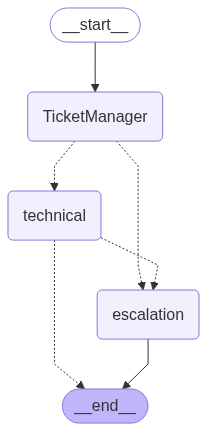

📋 Processing 4 sample support tickets...

🎫 Processing Ticket 1/4: TICK-001

TICKET SUMMARY: TICK-001
Customer: Avik Chakraborty (avik.chak@gmail.com)
Subject: Login Issues
Description: I can't log into my account. Getting 'invalid credentials' error even with correct password.
Category: Account
Priority: High
Status: escalated
Assigned to: Human Agent (Pending)

Processing Flow:
  • [TicketManager Agent] Ticket TicketManaged - Category: Account, Priority: High
  • [Escalation Agent] Case escalated to human agent with comprehensive handoff

Resolution:
  Escalated to human agent. Summary: The customer is experiencing login issues with their account, receiving an 'invalid credentials' error message despite entering what they believe to be the correct password. This is a high-priority issue that requires immediate attention. The customer has not specified any troubleshooting steps they have attempted, so it's important to verify their account status and reset their password if necessary.

In [8]:
if __name__ == "__main__":
    main()